In [1]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
from os import path
import json
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib

plt.style.use("bmh")
matplotlib.rcParams['figure.figsize'] = (7.0, 7.0)

In [4]:
data_dir = "data"

train = pd.read_csv(path.join(data_dir, "train_input.csv"), sep=';', index_col=0)
ages = pd.read_csv(path.join(data_dir, "train_output.csv"), sep=';', index_col=0)

In [5]:
train_hypno = train["HYPNOGRAM"]

In [6]:
def get_hypno(row):
    hypno = pd.Series(literal_eval(row)).astype(np.int8)
    return hypno

In [7]:
train_hypno = train_hypno.apply(get_hypno)

In [8]:
# we replace the nan values (because the hypnograms don't have the same lengths) with -2 
# so they are not confused with -1 (missing values)
train_hypno.fillna(-2, inplace=True) 
# then we fill the missing values with the previous valid value
train_hypno.replace(-1, np.nan, inplace=True)
train_hypno.fillna(method="ffill", axis=1, inplace=True)
# we reset -2 as nan
train_hypno.replace(-2, np.nan, inplace=True)

In [9]:
def get_duration_sleep(row):
    sleep = row.notnull().sum()
    return sleep*30

In [10]:
train["SLEEP_TIME"] = train_hypno.apply(get_duration_sleep, axis=1)

In [11]:
def get_duration_deep_sleep(row):
    deep_sleep = (row == 3).sum()
    return deep_sleep*30

In [12]:
train["DEEP_SLEEP_TIME"] = train_hypno.apply(get_duration_deep_sleep, axis=1)

In [13]:
def get_periods_deep_sleep(row):
    periods = []
    cnt = 1 * (row[0] == 3)
    for i in range(1, len(row)):
        if row[i] == 3:
            if row[i-1] != 3:
                cnt = 1
            else:
                cnt += 1
        else:
            if row[i-1] == 3:
                periods.append(cnt)
                cnt = 0
    if cnt > 0: periods.append(cnt)
    return pd.Series({"AVERAGE_DEEP_SLEEP": 30*np.mean(periods), "MAX_DEEP_SLEEP": 30*np.max(periods)})

In [14]:
train = train.merge(train_hypno.apply(get_periods_deep_sleep, axis=1), left_index=True, right_index=True)

In [15]:
train_ages = pd.concat([train[["SLEEP_TIME", "DEEP_SLEEP_TIME", 
                               "AVERAGE_DEEP_SLEEP",
                               "MAX_DEEP_SLEEP"]], ages], axis=1)

In [16]:
train_ages["RATIO"] = train_ages["DEEP_SLEEP_TIME"] / train_ages["SLEEP_TIME"]

In [17]:
train_ages["AGE_BIN"] = 5 * (train_ages["TARGET"] // 5)

In [18]:
agg_ages = train_ages.groupby("AGE_BIN").mean()

In [19]:
agg_ages.columns

Index(['SLEEP_TIME', 'DEEP_SLEEP_TIME', 'AVERAGE_DEEP_SLEEP', 'MAX_DEEP_SLEEP',
       'TARGET', 'RATIO'],
      dtype='object')

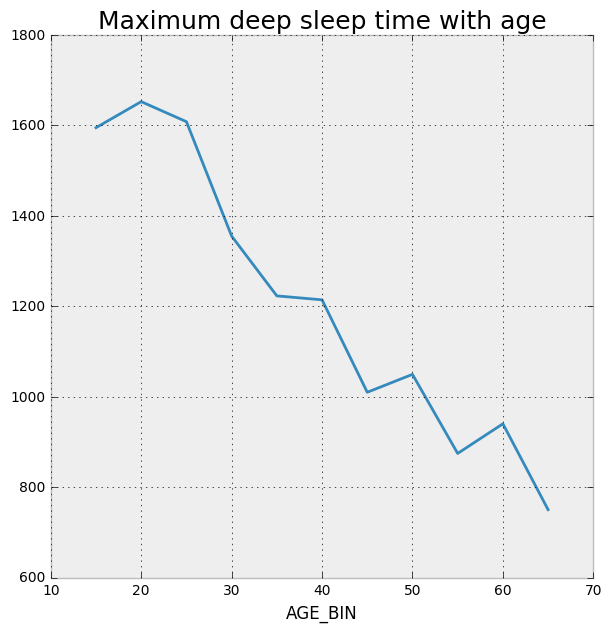

In [24]:
agg_ages["MAX_DEEP_SLEEP"].plot()
plt.axis('auto')
plt.title("Maximum deep sleep time with age", size=18)
plt.savefig(path.join("figures", "max_deep_sleep.png"), format="png")

In [14]:
from public_MAPE import score_function
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [15]:
data = train[["SLEEP_TIME", "DEEP_SLEEP_TIME", "AVERAGE_DEEP_SLEEP", "MAX_DEEP_SLEEP"]].values
ages = ages.values.ravel()

In [18]:
StdSc = StandardScaler()
data = StdSc.fit_transform(data, ages)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data, ages, test_size=0.3, random_state=42)

In [111]:
pca = PCA(n_components=2, random_state=42)
pca.fit(data, ages)
data_red = pca.transform(data, ages)

(-20000.0, 25000.0, -10000.0, 80000.0)

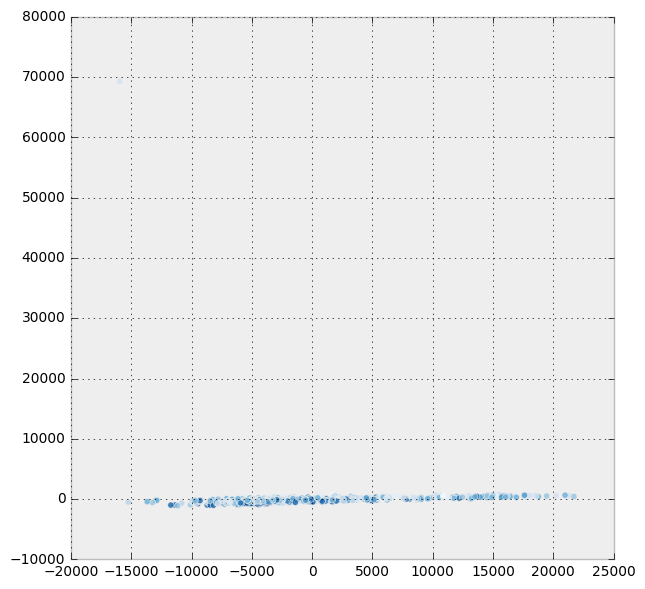

In [112]:
plt.scatter(data_red[:, 0], data_red[:, 1], c=ages//10, cmap=plt.get_cmap("Blues"), alpha=0.8)
plt.axis("auto")

In [20]:
reg = SVR(kernel="linear")
# reg = Ridge(random_state=42)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
score_function(y_test, pred)

[LibSVM]

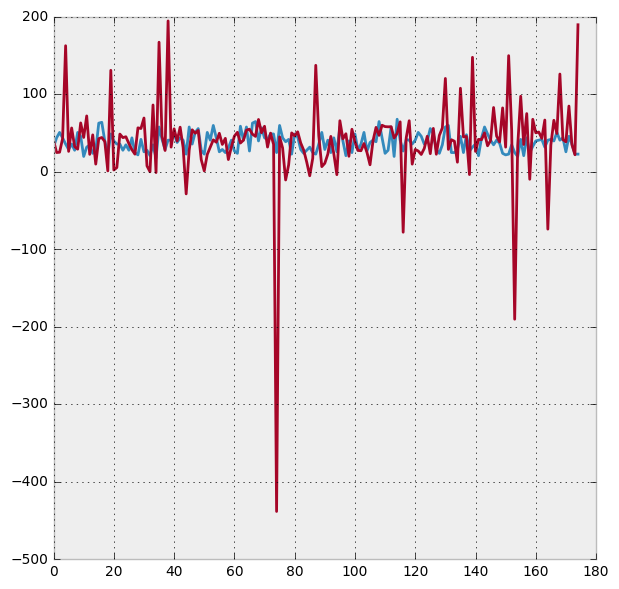

In [115]:
plt.plot(y_test)
plt.plot(pred)
plt.show()